In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [71]:
# Load the data from the assets folder

rain_data = pd.read_csv('../assets/rain_data.csv')

In [72]:

rain_data['Date'] = pd.to_datetime(rain_data['Date'])
rain_data['Month'] = rain_data['Date'].dt.month
rain_data['Day'] = rain_data['Date'].dt.day
rain_data['Year'] = rain_data['Date'].dt.year
rain_data.drop('Date', axis=1, inplace=True)

# Missings


,missing_values,percent_missing %,data type
Location,0,0.000000,object
MinTemp,1157,1.726325,float64
MaxTemp,1081,1.612927,float64
Rainfall,2750,4.103192,float64
Evaporation,29430,43.911610,float64
Sunshine,32190,48.029722,float64
WindGustDir,5487,8.186986,object
WindGustSpeed,5445,8.124319,float64
WindDir9am,4751,7.088823,object
WindDir3pm,2288,3.413855,object


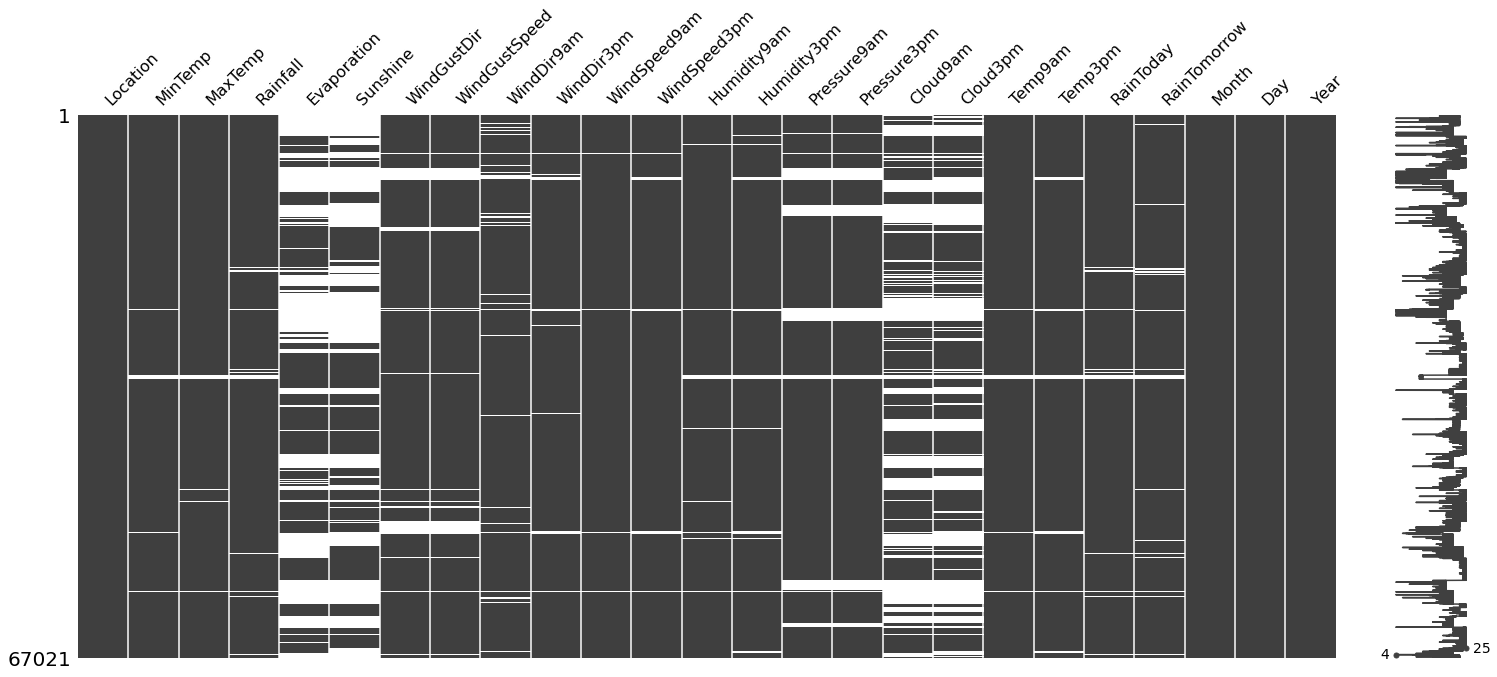

In [73]:
import missingno as msno

# Visualize the missing values as a matrix

msno.matrix(rain_data)

def create_missing_data_frame():
    # Create a table with data missing 
    missing_values=rain_data.isnull().sum() # missing values

    percent_missing = rain_data.isnull().sum()/rain_data.shape[0]*100 # missing value %

    value = {
        'missing_values ':missing_values,
        'percent_missing %':percent_missing , 
        'data type' : rain_data.dtypes
    }
    frame=pd.DataFrame(value)
    return frame

missing_data=create_missing_data_frame()
missing_data

Shape of the data: (32720, 25)


,missing_values,percent_missing %,data type
Location,0,0.000000,object
MinTemp,583,1.781785,float64
MaxTemp,576,1.760391,float64
Rainfall,838,2.561125,float64
Evaporation,0,0.000000,float64
Sunshine,0,0.000000,float64
WindGustDir,2265,6.922372,object
WindGustSpeed,2251,6.879584,float64
WindDir9am,1134,3.465770,object
WindDir3pm,403,1.231663,object


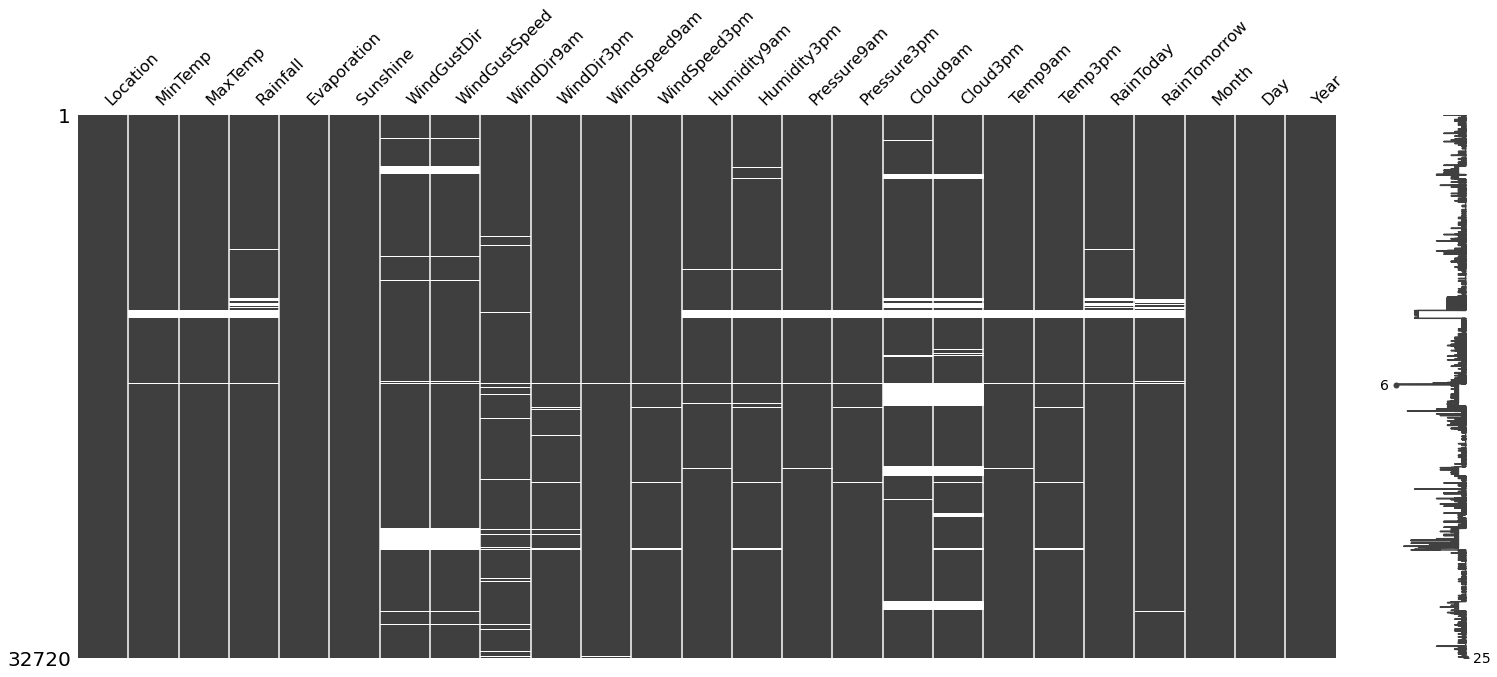

In [74]:
# Delete the rows that have missing values in 'Evaporation' and 'Sunshine'

rain_data.dropna(subset=['Evaporation', 'Sunshine'], inplace=True)
msno.matrix(rain_data)
missing_data=create_missing_data_frame()

print(f'Shape of the data: {rain_data.shape}')
missing_data

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def impute_dataset(data):
    # Separate numerical and categorical columns
    df = data.copy()
    categorical_cols = df.select_dtypes(include=['object']).columns
    numerical_cols = df.select_dtypes(exclude=['object']).columns
    
    # Imputation for numerical variables using MICE with KNN
    mice_imputer = IterativeImputer(estimator=KNeighborsRegressor(), initial_strategy='median', max_iter=5, tol=0.01, random_state=42)
    df[numerical_cols] = mice_imputer.fit_transform(df[numerical_cols])
    
    # Round Cloud9am and Cloud3pm after imputation for better interpretation
    cloud_cols = ['Cloud9am', 'Cloud3pm']
    for col in cloud_cols:
        df[col] = df[col].apply(lambda x: min(8, max(0, round(x))))
    
    # Imputation for categorical variables using Random Forest
    for column in categorical_cols:
        rf_imputer = RandomForestClassifier(n_estimators=100, random_state=42)
        non_na_data = df[df[column].notna()]
        na_data = df[df[column].isna()]
        if na_data.empty:
            continue
        rf_imputer.fit(non_na_data.drop(columns=categorical_cols), non_na_data[column])
        imputed_values = rf_imputer.predict(na_data.drop(columns=categorical_cols))
        df.loc[df[column].isna(), column] = imputed_values
    
    return df

In [76]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score



def hide_data(df, hide_ratio=0.1):
    """
    Randomly hides data in the DataFrame based on the specified ratio,
    except for the specified columns: 'Sunshine', 'Evaporation', 'Date', and 'Location'.
    """
    df_copy = df.copy()
    # Create a True/False mask for the entire DataFrame
    mask = np.random.rand(*df.shape) < hide_ratio

    # Convert the numpy array mask to a DataFrame to manipulate columns by name
    mask_df = pd.DataFrame(mask, columns=df.columns, index=df.index)

    # Exclude specified columns from the mask by setting them to False
    excluded_columns = ['Sunshine', 'Evaporation', 'Date', 'Location', 'month', 'day', 'year']
    mask_df[excluded_columns] = False

    # Apply the mask to df_copy to hide the data
    df_copy[mask_df] = np.nan
    original_data = df.where(mask_df)
    
    return df_copy, original_data

def evaluate_imputation(df, hide_ratio=0.1):
    df_hidden, original_data = hide_data(df, hide_ratio)
    df_imputed = impute_dataset(df_hidden)
    
    metrics_num = {}
    metrics_cat = {}

    for column in df.columns:
        if column in ['Sunshine', 'Evaporation', 'Date', 'Location', 'month', 'day', 'year']:
            continue
        if df[column].dtype in ['float64', 'int64']:
            valid_index = original_data[column].dropna().index.intersection(df_imputed.index)
            if not valid_index.empty:
                mse = mean_squared_error(original_data[column].loc[valid_index], df_imputed[column].loc[valid_index])
                r2 = r2_score(original_data[column].loc[valid_index], df_imputed[column].loc[valid_index])
                # Storing metrics for each numerical variable
                metrics_num[column] = {
                    'MSE': mse,
                    'R2': r2,
                }
        elif df[column].dtype == 'object':
            valid_index = original_data[column].dropna().index.intersection(df_imputed.index)
            if not valid_index.empty:
                accuracy = accuracy_score(original_data[column].loc[valid_index], df_imputed[column].loc[valid_index])
                f1 = f1_score(original_data[column].loc[valid_index], df_imputed[column].loc[valid_index], average='weighted')
                # Storing metrics for each categorical variable
                metrics_cat[column] = {
                    'Accuracy': accuracy,
                    'F1 Score': f1
                }
    
    return metrics_num, metrics_cat

# Evaluate the imputation performance
evaluate_imputation_dataset = rain_data.copy()
metrics_num, metrics_cat = evaluate_imputation(evaluate_imputation_dataset, hide_ratio=0.1)

# Convert the results to DataFrames for better visualization
df_metrics_num = pd.DataFrame(metrics_num).T
df_metrics_cat = pd.DataFrame(metrics_cat).T

KeyboardInterrupt: 

In [8]:
# Print the results
print("Numerical Variables Imputation Metrics:")
df_metrics_num

Numerical Variables Imputation Metrics:


NameError: name 'df_metrics_num' is not defined

In [ ]:
print("Categorical Variables Imputation Metrics:")
df_metrics_cat

c:\Users\llucfurriols\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


<AxesSubplot:>

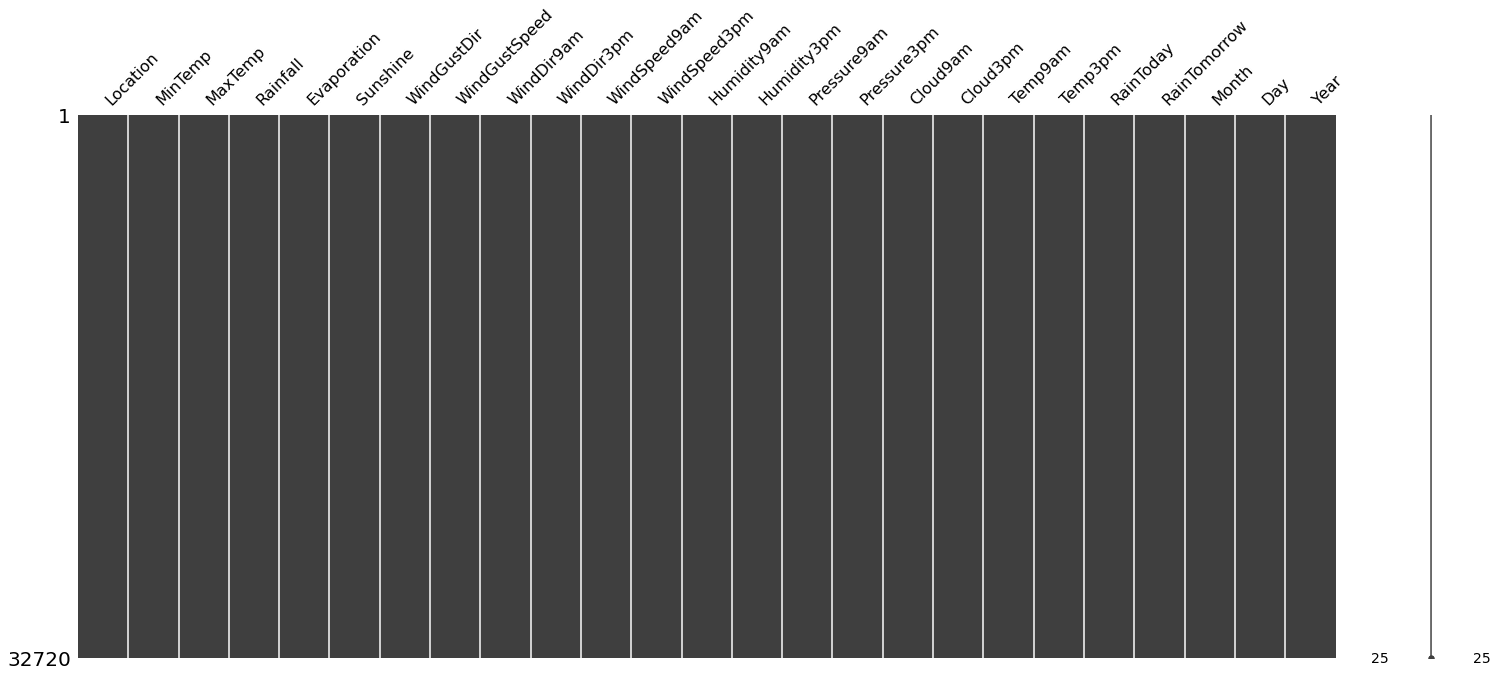

In [77]:
imputed_rain_data = impute_dataset(rain_data)

# Visualize that there are no missing values
msno.matrix(imputed_rain_data)

In [78]:
print(imputed_rain_data.isnull().sum())

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Month            0
Day              0
Year             0
dtype: int64


In [79]:
rain_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
rain_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [80]:
rain_data.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday        float64
RainTomorrow     float64
Month              int64
Day                int64
Year               int64
dtype: object

In [81]:
variable_stats = rain_data.describe().transpose()
variable_stats


,count,mean,std,min,25%,50%,75%,max
MinTemp,32137.0,13.272113,6.311848,-6.7,8.5,12.8,17.9,33.9
MaxTemp,32144.0,22.846942,6.882696,7.0,17.4,22.1,28.1,46.8
Rainfall,31882.0,3.192651,8.560365,0.0,0.0,0.0,2.2,206.2
Evaporation,32720.0,4.944609,3.447049,0.0,2.4,4.2,6.8,60.2
Sunshine,32720.0,6.488072,3.919063,0.0,3.2,6.8,9.8,14.5
WindGustSpeed,30469.0,42.798549,14.560212,11.0,33.0,41.0,52.0,135.0
WindSpeed9am,32570.0,15.504943,9.014553,0.0,9.0,15.0,20.0,67.0
WindSpeed3pm,32458.0,20.019687,8.928762,0.0,13.0,19.0,26.0,76.0
Humidity9am,31983.0,70.339462,18.145035,0.0,59.0,72.0,84.0,100.0
Humidity3pm,31888.0,56.614745,21.060954,0.0,42.0,57.0,71.0,100.0


In [82]:
#information about categorical variables including RainToday and RainTomorrow

rain_data.select_dtypes(include='object').nunique()

Location       29
WindGustDir    16
WindDir9am     16
WindDir3pm     16
dtype: int64

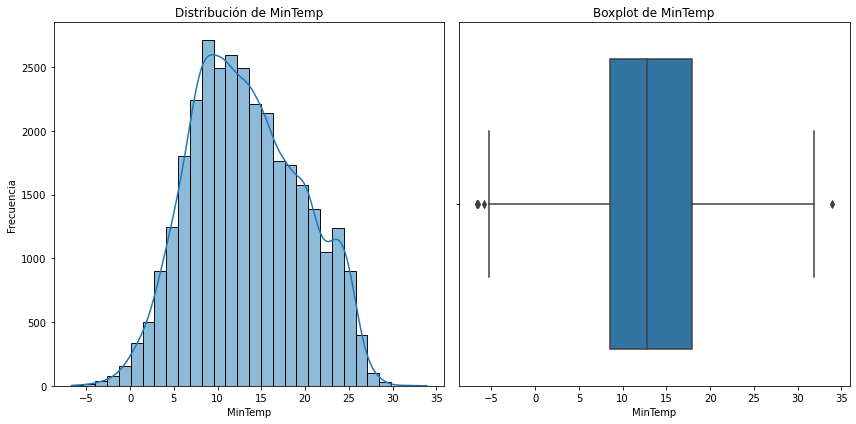

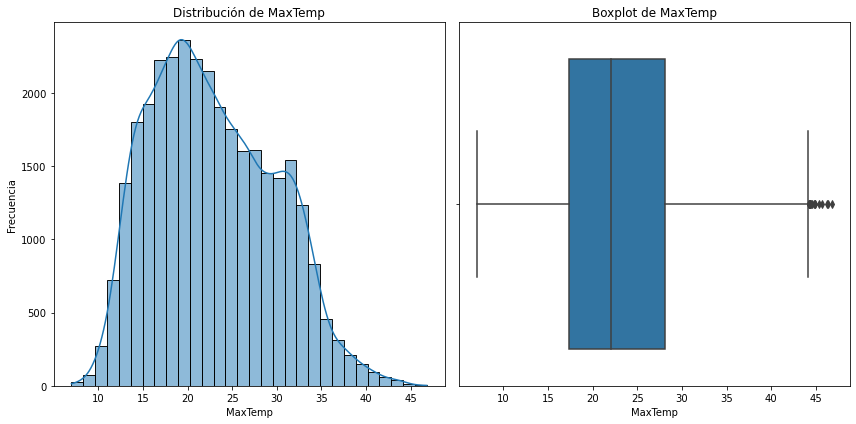

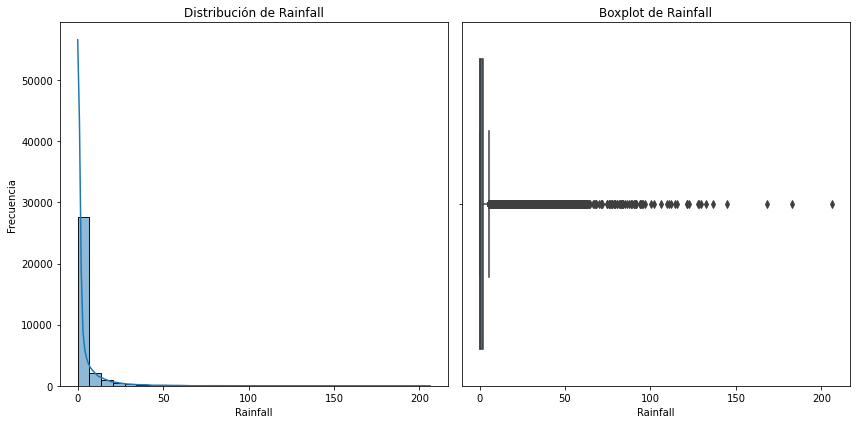

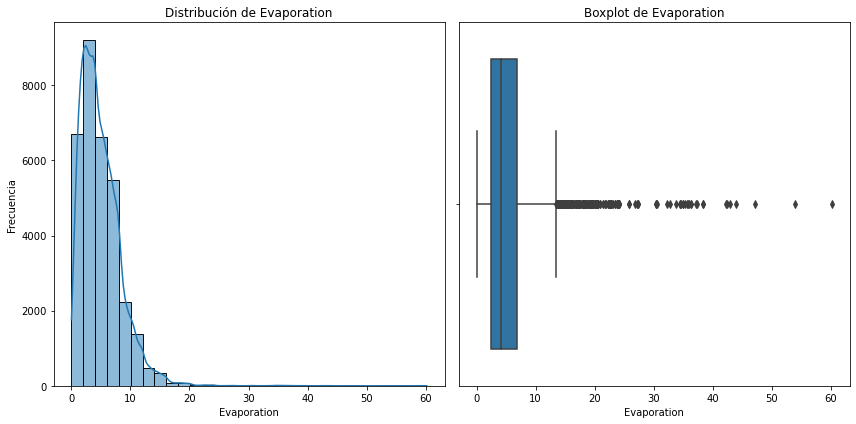

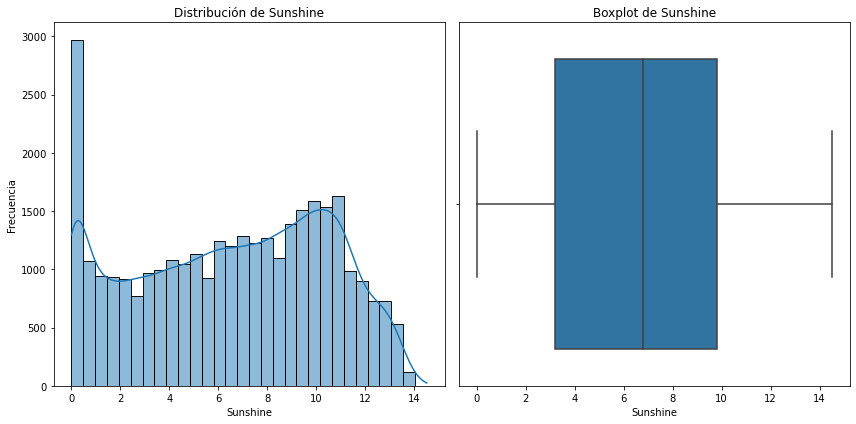

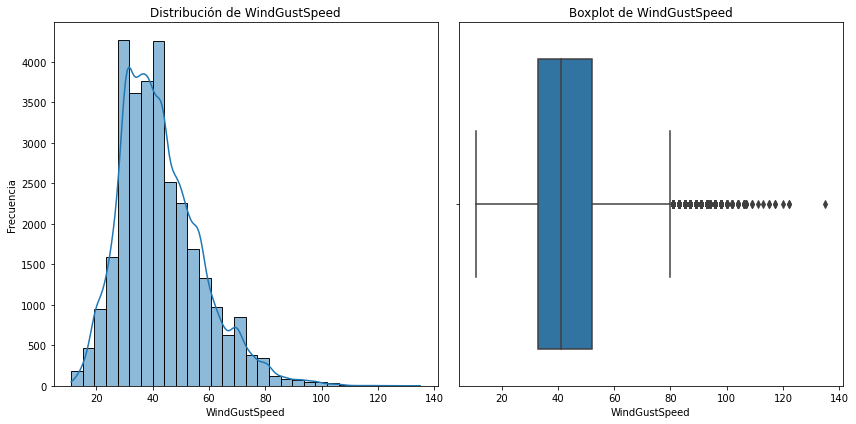

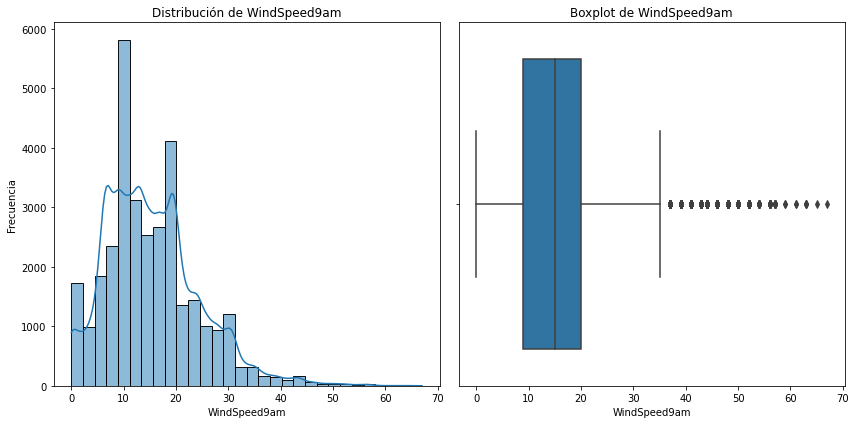

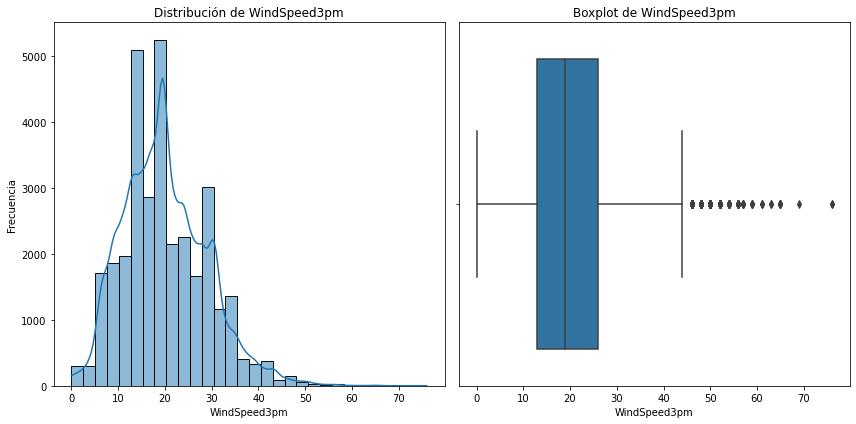

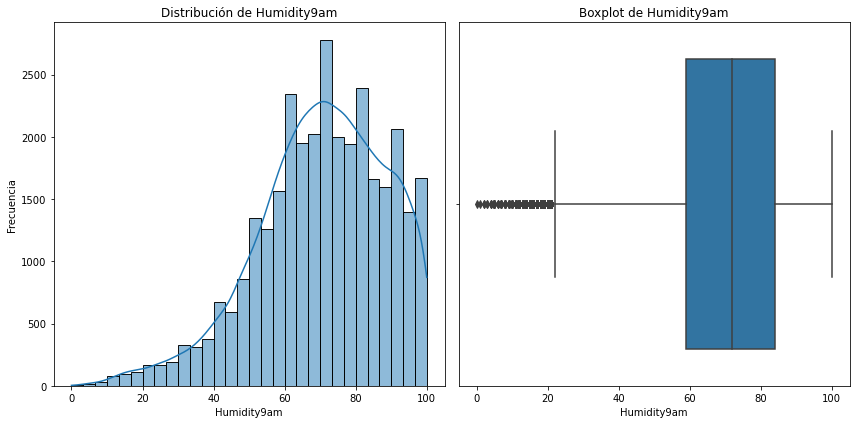

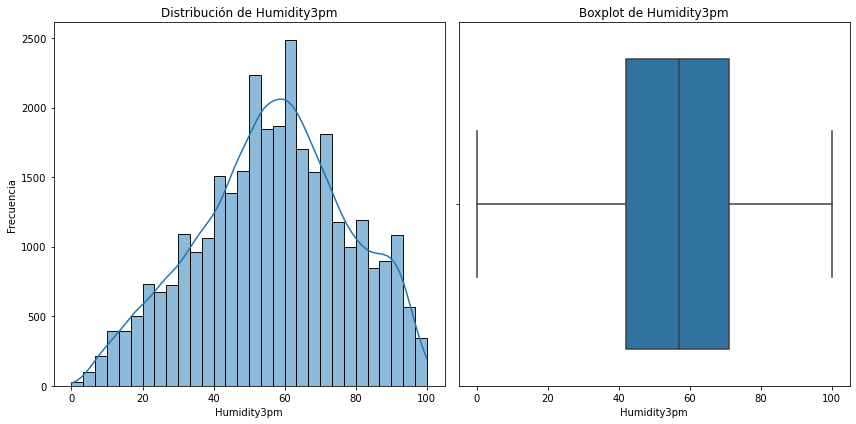

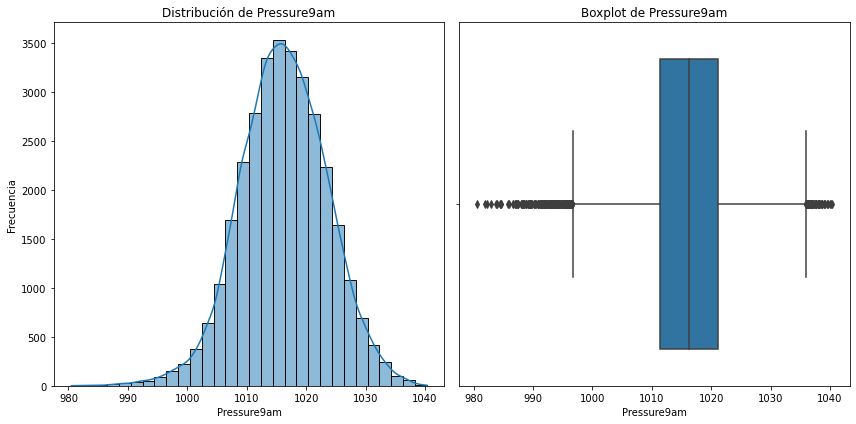

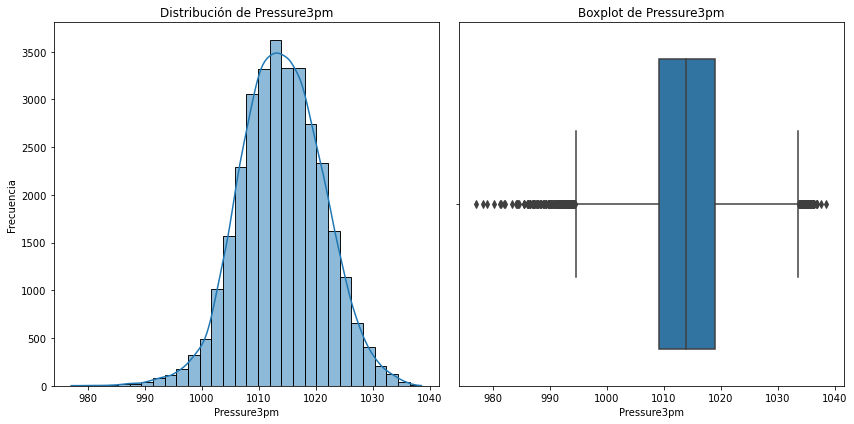

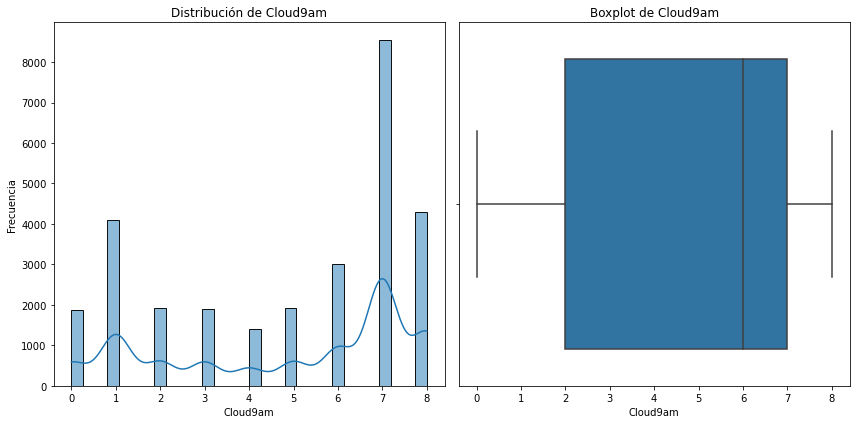

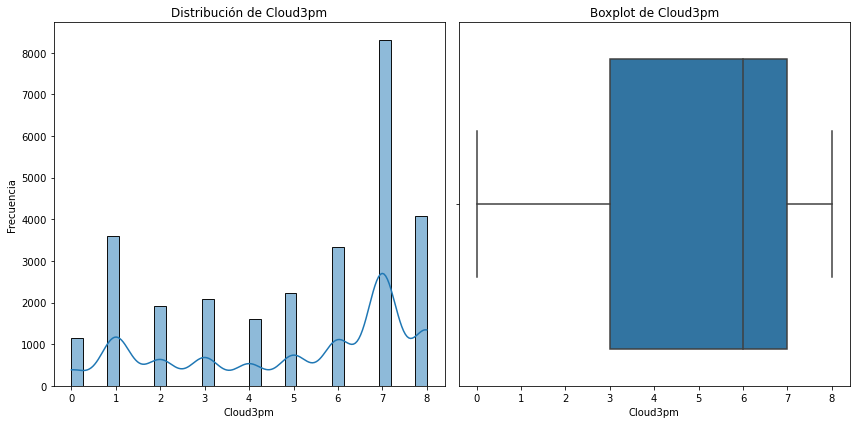

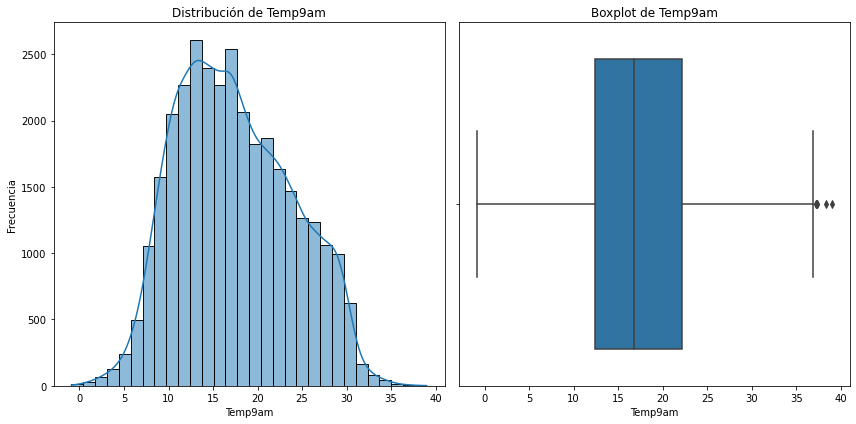

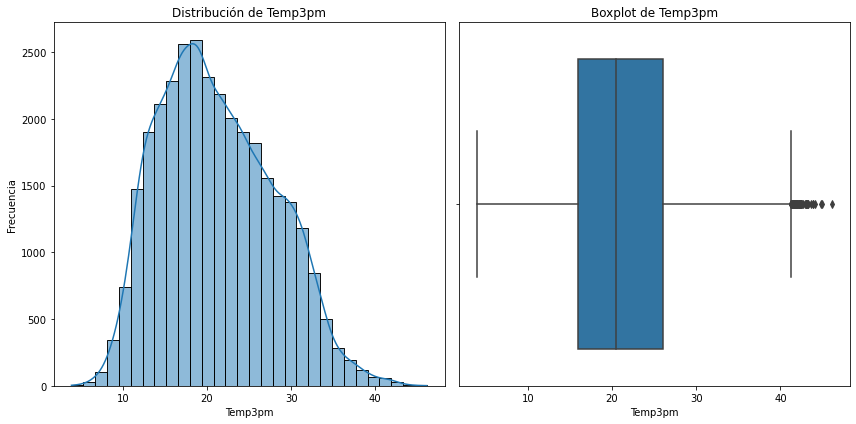

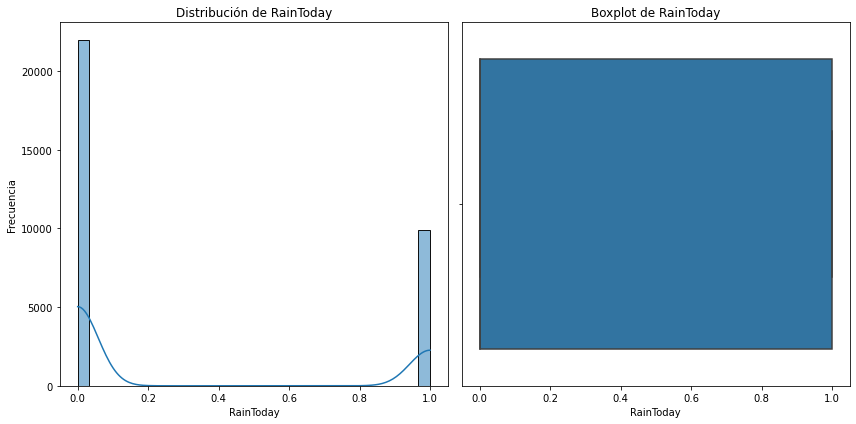

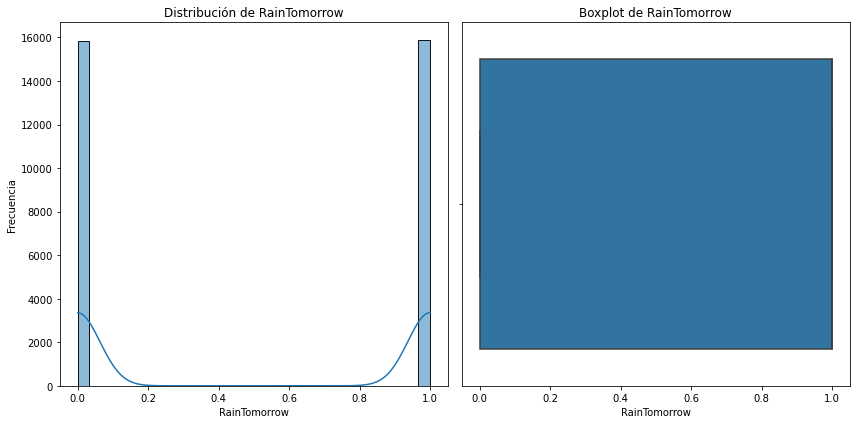

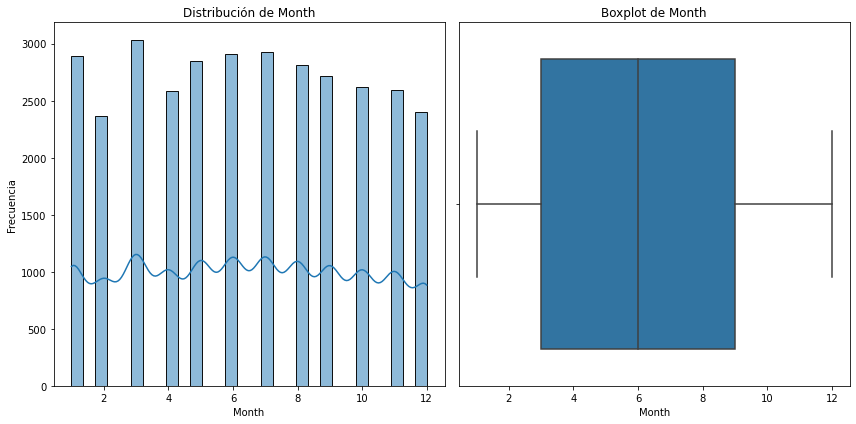

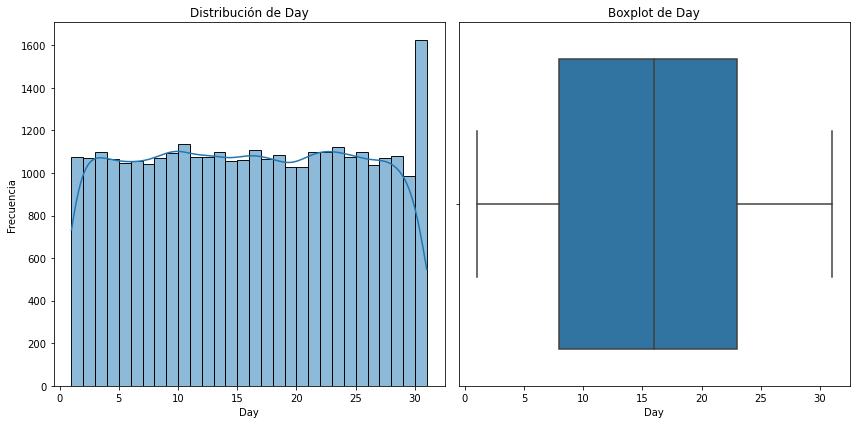

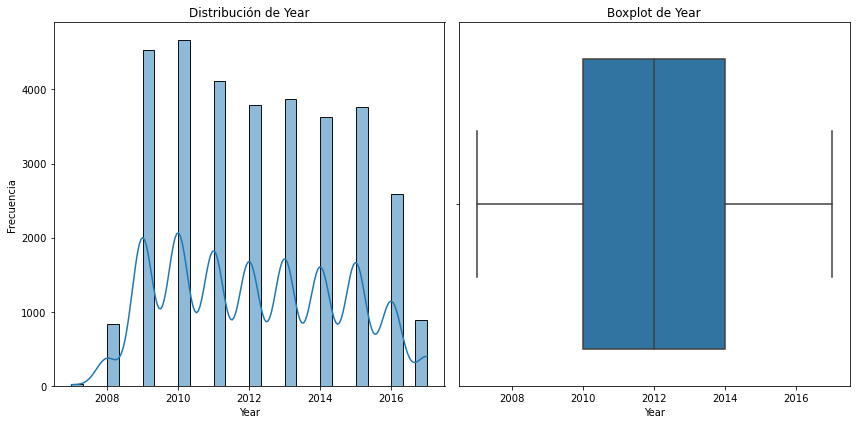

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráficos numéricos
numeric_columns = rain_data.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:
    plt.figure(figsize=(12, 6))

    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(rain_data[column], bins=30, kde=True)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=rain_data[column])
    plt.title(f'Boxplot de {column}')

    plt.tight_layout()
    plt.show()


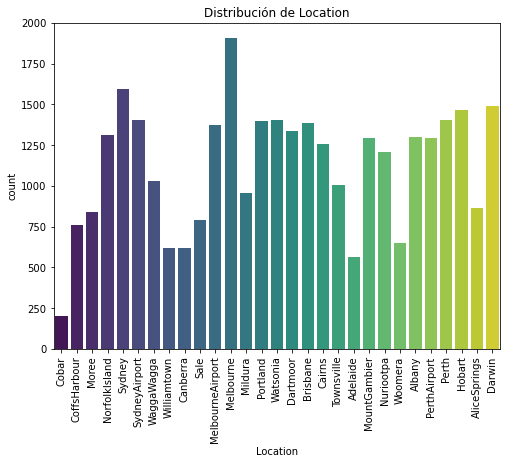

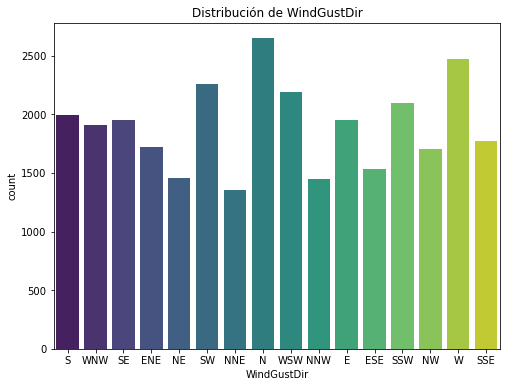

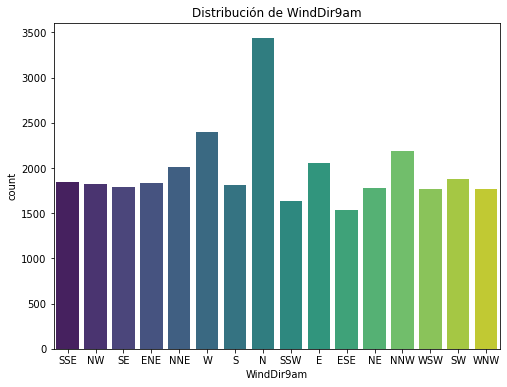

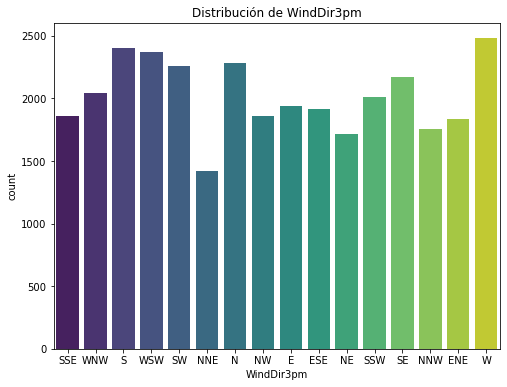

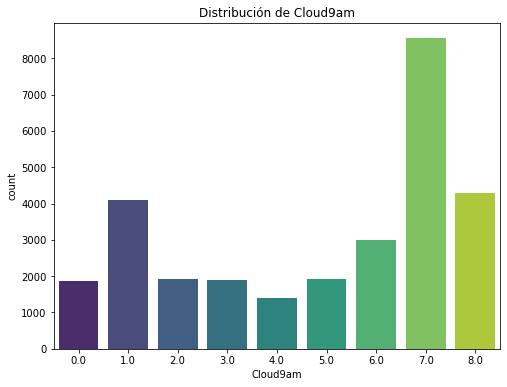

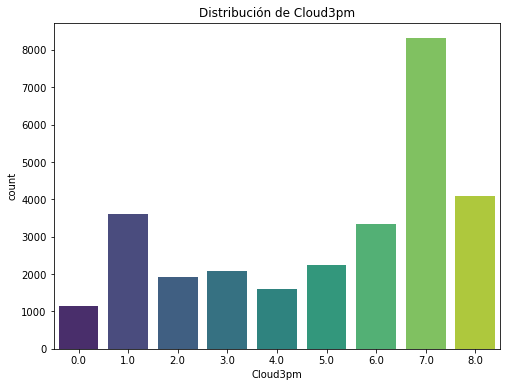

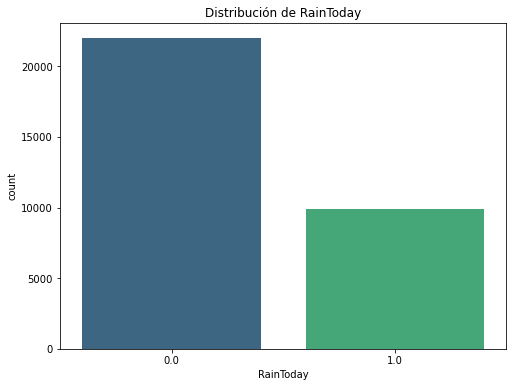

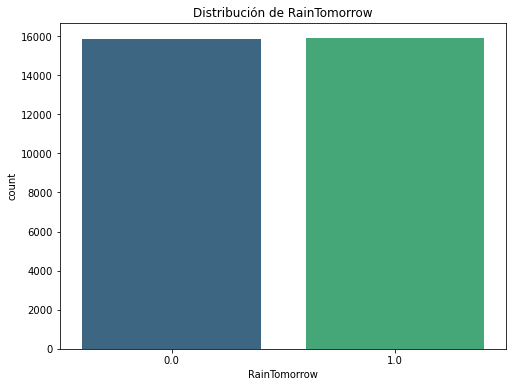

In [84]:
categorical_columns = rain_data.select_dtypes(include=['object']).columns
#also include 'Cloud9am' and 'Cloud3am' as categorical variable
categorical_columns = categorical_columns.append(pd.Index(['Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow']))

#Exclude the 'Date' column

for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=rain_data[column], palette="viridis")
    plt.title(f'Distribución de {column}')
    if column == 'Location':
        plt.xticks(rotation=90)
    plt.show()


## Correlation between variables

In [85]:
target = imputed_rain_data['RainTomorrow']


In [87]:
!pip install yellowbrick

   ---------------------------------------- 282.6/282.6 kB 2.5 MB/s eta 0:00:00


In [88]:
from yellowbrick.target import FeatureCorrelation

feature_names = list(imputed_rain_data.drop(['RainTomorrow'],axis=1).columns)

visualizer = FeatureCorrelation(labels = feature_names)
visualizer.fit(imputed_rain_data.drop(['RainTomorrow'],axis=1), target)
visualizer.poof()

TypeError: unsupported operand type(s) for +: 'float' and 'str'

<AxesSubplot:>

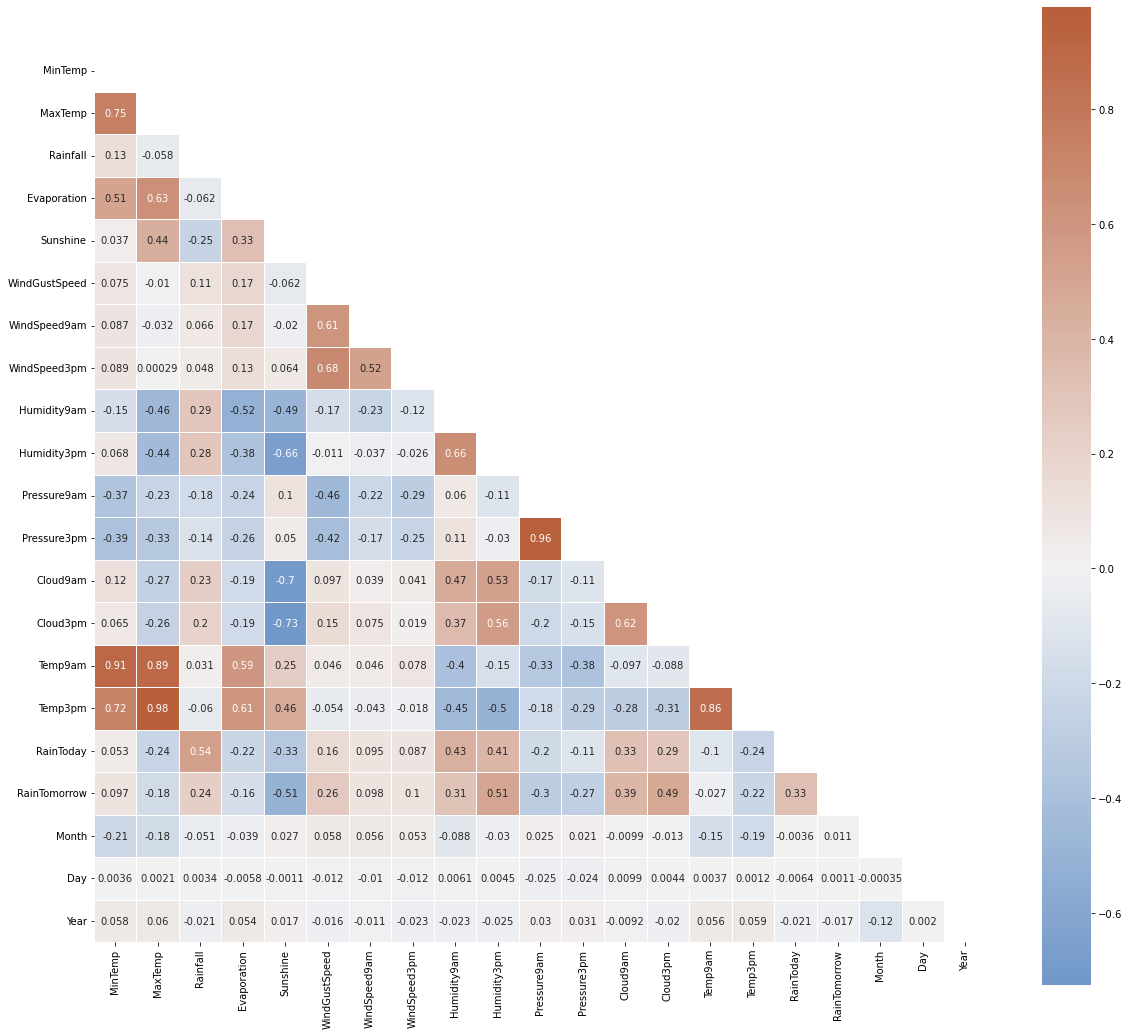

In [ ]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


correlation_matrix = rain_data.select_dtypes(include=['float64', 'int64']).corr()
mask = np.triu(np.ones_like(correlation_matrix))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

# Outliers

In [ ]:
numeric_columns = imputed_rain_data.select_dtypes(include=['float64', 'int64']).columns

## Isolation forest

#### Estimating the percentage of outliers:

In [ ]:

lower_bound = imputed_rain_data.quantile(0.01)
upper_bound = imputed_rain_data.quantile(0.99)

num_outliers = ((imputed_rain_data < lower_bound) | (imputed_rain_data > upper_bound)).sum().sum()

contamination = num_outliers / imputed_rain_data.size

print(f'Estimated proportion of outliers: {contamination}')


Estimated proportion of outliers: 0.008575794621026894


C:\Users\llucfurriols\AppData\Local\Temp\ipykernel_9608\3542423103.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  num_outliers = ((imputed_rain_data < lower_bound) | (imputed_rain_data > upper_bound)).sum().sum()


## Identifying outliers:

In [ ]:

from sklearn.ensemble import IsolationForest

imputed_rain_data = pd.get_dummies(imputed_rain_data)


iso = IsolationForest(contamination=contamination, random_state=42)

iso.fit(imputed_rain_data)

outliers_iso = iso.predict(imputed_rain_data)

#outliers are marked as -1 and inliers are marked as 1
imputed_rain_data['outlier'] = outliers_iso




c:\Users\llucfurriols\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


## Interquartile range

In [ ]:

def find_outliers_iqr(data, numerical_columns, categorical_columns=None):
    """
    Find outliers using the interquartile range (IQR) method for numerical variables.
    
    Args:
    - data: DataFrame containing the dataset.
    - numerical_columns: List of numerical variable names.
    - categorical_columns: List of categorical variable names (optional).
    
    Returns:
    - outliers_dict: Dictionary containing outliers for each numerical variable.
    """
    outliers_dict = {}
    
    # Calculate IQR and identify outliers for each numerical variable
    for col in numerical_columns:
        # Calculate quartiles
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Find outliers
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        outliers = [(index, value) for index, value in data[col].items() if (value < lower_bound) or (value > upper_bound)]  # Storing index and value as a tuple
        
        outliers_dict[col] = outliers
    
    return outliers_dict

# Example usage:
# numerical_columns = [...]  # List of numerical variable names
# categorical_columns = [...]  # List of categorical variable names
# outliers = find_outliers_iqr(rain_data_imputed, numerical_columns, categorical_columns)


In [ ]:
# Find outliers using the IQR method
outliers_iqr = find_outliers_iqr(imputed_rain_data, numeric_columns)



In [ ]:

print(f'Number of outliers detected using the IQR method: {sum(len(outliers_iqr[category]) for category in outliers_iqr)}')
print(f'Number of outliers detected using the Isolation Forest method: {len(imputed_rain_data[imputed_rain_data["outlier"] == -1])}')




Number of outliers detected using the IQR method: 9023
Number of outliers detected using the Isolation Forest method: 3272


In [65]:
print(imputed_rain_data.iloc[outliers_iqr['MinTemp']])

IndexError: positional indexers are out-of-bounds

In [66]:
print(outliers_iqr['MinTemp'])

[(21499, -5.8), (21777, -6.5), (21804, -6.7), (21963, -6.6), (44898, 33.9)]
